In [56]:
import json
import os
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import math

# ======================
# CONSTANTES GLOBAIS
# ======================

# GASTO CALÓRICO POR ATIVIDADE
KCAL_KARATE = 1000      # 120 minutos
KCAL_CALISTENIA = 300   # 100 repetições
KCAL_CORRIDA = 100      # por km
KCAL_BIKE = KCAL_CORRIDA / 3  # per km (3km = 100kcal)

# CONSTANTES METABÓLICAS
BASAL = 2300            # Taxa metabólica basal
KCAL_POR_KG = 7000      # 7000kcal = 1kg
AGUA_Q10 = 5000         # 5L de água no Q10
MAX_DEFICIT_ALIMENTAR = 1300  # Déficit máximo via alimentação

# ======================
# FUNÇÕES DO PRIMEIRO ARQUIVO
# ======================

def f(x):
    """Função de progressão da perda de peso."""
    return 0.6 * (10 ** (x / 14))

def configurar_quadrantes():
    """Configura dias e metas por quadrante."""
    x_points = np.arange(0, 15, 1)
    y_plan = f(x_points)
    
    # Ajustar soma total para ~43kg
    target_total = 43
    scale_factor = target_total / np.sum(y_plan[1:15])
    y_plan *= scale_factor
    y_plan[0] = 0  # Quadrante 0 = 0kg
    
    # Dias por quadrante (Q0 a Q14)
    dias_por_quadrante = [0]  # Q0
    for _ in range(1, 4): dias_por_quadrante.append(5)    # Q1-Q3: verde
    for _ in range(4, 8): dias_por_quadrante.append(7)    # Q4-Q7: azul
    for _ in range(8, 15): dias_por_quadrante.append(10)  # Q8-Q14: roxo
    
    return x_points, y_plan, dias_por_quadrante

# Configura quadrantes uma vez para todo o programa
x_points, y_plan, dias_por_quadrante = configurar_quadrantes()
data_inicio_padrao = datetime(2025, 7, 20)

# ======================
# CALCULADORA DE CALISTENIA
# ======================

def fibonacci_sequence(n, min_val=1):
    """Gera sequência Fibonacci até atingir n valores, começando no primeiro valor >= min_val."""
    if n <= 0:
        return []
    a, b = 1, 1
    sequence = []
    while a < min_val:
        a, b = b, a + b
    for _ in range(n):
        sequence.append(a)
        a, b = b, a + b
    return sequence

def redistribute_small_values(block, subblocks):
    """Redistribui valores <=5 combinando-os com elementos adjacentes."""
    if all(x > 5 for x in subblocks) or len(subblocks) == 1:
        return subblocks
    
    result = []
    temp = 0
    for val in subblocks:
        if val <= 5:
            temp += val
        else:
            if temp > 0:
                if result:
                    result[-1] += temp
                else:
                    result.append(temp)
                temp = 0
            result.append(val)
    
    if temp > 0:
        if result:
            result[-1] += temp
        else:
            result.append(temp)
    
    if result and result[0] <= 5 and len(result) > 1:
        result[1] += result[0]
        result = result[1:]
    
    if any(x <= 5 for x in result) and len(result) > 1:
        return redistribute_small_values(block, result)
    
    if sum(result) != block:
        diff = block - sum(result)
        result[-1] += diff
    
    return result

def adjust_blocks(blocks, min_val=6):
    """Garante que todos os blocos principais tenham pelo menos min_val."""
    total = sum(blocks)
    n = len(blocks)
    
    if total < min_val * n:
        return blocks
    
    adjusted = blocks[:]
    
    for i in range(n-1, -1, -1):
        if adjusted[i] < min_val:
            needed = min_val - adjusted[i]
            for j in range(i):
                if adjusted[j] > min_val and adjusted[j] >= needed:
                    adjusted[j] -= needed
                    adjusted[i] = min_val
                    break
            else:
                if adjusted[0] >= needed:
                    adjusted[0] -= needed
                    adjusted[i] = min_val
    
    if all(x >= min_val for x in adjusted):
        return adjusted
    
    for i in range(n-1, -1, -1):
        if adjusted[i] < min_val:
            needed = min_val - adjusted[i]
            for j in range(n):
                if j != i and adjusted[j] >= needed:
                    adjusted[j] -= needed
                    adjusted[i] += needed
                    break
    
    return adjusted

def calculate_blocks(total, num_blocks, num_subblocks):
    fib_blocks = fibonacci_sequence(num_blocks, min_val=2)
    sum_fib_blocks = sum(fib_blocks)
    
    blocks = [round((f/sum_fib_blocks) * total) for f in fib_blocks]
    
    diff = total - sum(blocks)
    blocks[-1] += diff
    
    blocks.sort(reverse=True)
    blocks = adjust_blocks(blocks, min_val=6)
    
    subblocks_table = []
    for i, block in enumerate(blocks):
        current_subblocks = max(1, num_subblocks - i)
        min_sub_val = 1 if block < 15 else 2
        fib_subs = fibonacci_sequence(current_subblocks, min_val=min_sub_val)
        
        sum_fib_subs = sum(fib_subs) or 1
        subblocks = [round((f/sum_fib_subs) * block) for f in fib_subs]
        
        diff = block - sum(subblocks)
        if subblocks:
            subblocks[-1] += diff
        
        if len(subblocks) > 1:
            subblocks = redistribute_small_values(block, subblocks)
        
        subblocks.sort(reverse=True)
        subblocks_table.append(subblocks)
    
    return blocks, subblocks_table

def automatic_training(total):
    """Calcula automaticamente os parâmetros para um treino baseado no total de repetições."""
    # Definir número de blocos baseado no total
    if total <= 50:
        num_blocks = 3
    elif total <= 100:
        num_blocks = 4
    elif total <= 200:
        num_blocks = 5
    elif total <= 300:
        num_blocks = 6
    else:
        num_blocks = 7
    
    # Definir número de subblocos baseado no total
    if total <= 50:
        num_subblocks = 3
    elif total <= 100:
        num_subblocks = 4
    elif total <= 200:
        num_subblocks = 5
    elif total <= 300:
        num_subblocks = 6
    else:
        num_subblocks = 7
    
    print(f"Modo automático: {total} repetições, {num_blocks} blocos, {num_subblocks} subblocos")
    return calculate_blocks(total, num_blocks, num_subblocks)

def format_output(total, blocks, subblocks):
    print(f"\nDESAFIO {total}x")
    for i in range(len(blocks)):
        sub_str = ', '.join(map(str, subblocks[i]))
        print(f"{blocks[i]}x = [{sub_str}]")

def calculadora_calistenia():
    """Função interativa para calcular divisão de exercícios de calistenia."""
    print("\n" + "="*50)
    print("🧮 CALCULADORA DE CALISTENIA")
    print("="*50)
    
    total = int(input("Valor total de repetições (0 para modo automático): "))
    
    if total == 0:
        auto_total = int(input("Total de repetições para o treino automático: "))
        blocks, subblocks = automatic_training(auto_total)
        format_output(auto_total, blocks, subblocks)
    else:
        num_blocks = int(input("Número de blocos principais: "))
        num_subblocks = int(input("Número de subblocos por bloco: "))
        blocks, subblocks = calculate_blocks(total, num_blocks, num_subblocks)
        format_output(total, blocks, subblocks)
    
    input("\nPressione Enter para continuar...")

# ======================
# FUNÇÕES AUXILIARES
# ======================

def arredondar_500(valor):
    """Arredonda valores para o múltiplo de 500 mais próximo."""
    return round(valor / 500) * 500

def determinar_fase(quadrante):
    """Classifica a fase do quadrante."""
    if quadrante <= 3:
        return "verde"
    elif quadrante <= 7:
        return "azul"
    return "roxo"

def calcular_atividades_base(quadrante):
    """Calcula atividades físicas base para o quadrante."""
    # Progressão em relação ao Q10
    fator_q10 = quadrante / 10.0
    
    reps = max(1, round(10 * fator_q10 * 10))
    km_corrida = max(1, round(1 * fator_q10 * 10, 1))
    km_bike = max(1, round(3 * fator_q10 * 10, 1))
    
    return [
        ("Calistenia", f"{reps} reps", (reps / 100) * KCAL_CALISTENIA),
        ("Corrida", f"{km_corrida} km", km_corrida * KCAL_CORRIDA),
        ("Bike", f"{km_bike} km", km_bike * KCAL_BIKE)
    ]

def calcular_meta_karate_diaria(dia_semana, quadrante):
    """Calcula a meta diária de karatê baseada no dia da semana e quadrante."""
    if dia_semana in ["segunda", "quarta"]:
        # Segunda e quarta: 100% do Q10 (120 minutos)
        return 120, KCAL_KARATE
    else:
        # Outros dias: proporcional ao quadrante vigente
        minutos_karate = (quadrante / 10.0) * 120
        kcal_karate = (minutos_karate / 120) * KCAL_KARATE
        return minutos_karate, kcal_karate

def ajustar_karate(dia_semana, quadrante, plano_atual, deficit_restante):
    """Adiciona sessões de karatê conforme necessário."""
    if quadrante < 3:
        return 0, plano_atual
    
    # Calcular meta de karatê para o dia
    meta_minutos, meta_kcal = calcular_meta_karate_diaria(dia_semana, quadrante)
    
    # Karatê obrigatório (seg/qua) - sempre adiciona 120min
    if dia_semana in ["segunda", "quarta"]:
        plano_atual.append(("Karate Obrigatório", "120 min", KCAL_KARATE))
        return KCAL_KARATE, plano_atual
    
    # Para outros dias, adiciona karatê proporcional se necessário para o déficit
    if deficit_restante > 250:
        # Calcula minutos proporcionais ao déficit restante, mas não excede a meta
        minutos_karate = min(meta_minutos, (deficit_restante / KCAL_KARATE) * 120)
        if minutos_karate >= 30:
            kcal_karate = (minutos_karate / 120) * KCAL_KARATE
            tipo_karate = "Karate Diário" if minutos_karate >= meta_minutos * 0.8 else "Karate Opcional"
            plano_atual.append((tipo_karate, f"{minutos_karate:.0f} min", kcal_karate))
            return kcal_karate, plano_atual
    
    return 0, plano_atual

def carregar_dados_reais():
    """Carrega dados reais do arquivo JSON."""
    dados_padrao = {
        "peso_inicial": 112.4,
        # [112.4, 110.7, 112.0, 110.0, 111.1, 108.3, 109.0, 108.4, futuro=[105, 100, 94]]   
        "dados_reais": [0, 1.7, -1.3, 2, -1.1, 2.8, -0.7, 0.6, 3.6, 5.4, 9],
        "quadrante_atual": 6,
        "data_inicio": "2025-07-20"
    }
    
    try:
        with open('dados_reais.json', 'r') as f:
            dados = json.load(f)
            if len(dados["dados_reais"]) < 7:
                dados["dados_reais"] = dados_padrao["dados_reais"]
            return dados
    except FileNotFoundError:
        return dados_padrao

def calcular_data_inicio_quadrante(quadrante):
    """Calcula a data de início correta para cada quadrante."""
    dados = carregar_dados_reais()
    
    if isinstance(dados["data_inicio"], str):
        data_inicio = datetime.strptime(dados["data_inicio"], "%Y-%m-%d")
    else:
        data_inicio = data_inicio_padrao
    
    # Calcular dias acumulados até o início do quadrante
    dias_acumulados = sum(dias_por_quadrante[1:quadrante])
    return data_inicio + timedelta(days=dias_acumulados)

def calcular_quadrante_atual():
    """Calcula o quadrante atual com base na data."""
    dados = carregar_dados_reais()
    
    if isinstance(dados["data_inicio"], str):
        data_inicio = datetime.strptime(dados["data_inicio"], "%Y-%m-%d")
    else:
        data_inicio = data_inicio_padrao
    
    data_atual = datetime.now()
    dias_decorridos = (data_atual - data_inicio).days
    
    # Calcular em qual quadrante estamos
    dias_acumulados = 0
    for i, dias_quad in enumerate(dias_por_quadrante):
        if i == 0:  # Pular quadrante 0
            continue
        dias_acumulados += dias_quad
        if dias_decorridos < dias_acumulados:
            return i
    
    return 14

def calcular_desvio_acumulado(quadrante_atual):
    """Calcula o desvio acumulado com base nos dados reais."""
    dados = carregar_dados_reais()
    dados_reais = dados["dados_reais"]
    
    # Calcular perda real acumulada
    perda_real_acumulada = sum(dados_reais)
    
    # Calcular perda planejada acumulada até o quadrante atual
    perda_planejada_acumulada = np.sum(y_plan[1:quadrante_atual+1])
    
    # Calcular desvio (diferença entre planejado e realizado)
    desvio = perda_planejada_acumulada - perda_real_acumulada
    return desvio

def calcular_meta_proximo_quadrante(quadrante_atual):
    """Calcula la meta necessária para o próximo quadrante."""
    # Calcular desvio acumulado
    desvio = calcular_desvio_acumulado(quadrante_atual)
    
    # Meta planejada para o próximo quadrante
    if quadrante_atual + 1 < len(y_plan):
        meta_planejada = y_plan[quadrante_atual + 1]
    else:
        meta_planejada = y_plan[-1]
    
    # Meta ajustada = planejada + desvio acumulado
    meta_ajustada = meta_planejada + desvio
    
    return max(0.1, meta_ajustada)

# ======================
# FUNÇÃO PRINCIPAL COM REGRAS DE KARATÊ CORRIGIDAS
# ======================

def calcular_plano(quadrante, meta_kg=None, dias=None, data_inicio_quad=None):
    """Calcula plano detalhado para o quadrante especificado."""
    # Configurar data de início
    if quadrante == 0:
        fase = "EMERGÊNCIA"
        desvio_acumulado = 0
        if not all([meta_kg, dias, data_inicio_quad]):
            raise ValueError("Para emergência, informe meta_kg, dias e data_inicio_quad")
    else:
        if quadrante < 1 or quadrante > 14:
            raise ValueError("Quadrante deve estar entre 1-14")
            
        fase = determinar_fase(quadrante)
        dias = dias_por_quadrante[quadrante]
        data_inicio_quad = calcular_data_inicio_quadrante(quadrante)
        
        # Se não foi fornecida meta, calcular com base no desvio
        if meta_kg is None:
            desvio_acumulado = calcular_desvio_acumulado(quadrante - 1)
            meta_kg = y_plan[quadrante] + desvio_acumulado
        else:
            desvio_acumulado = meta_kg - y_plan[quadrante]
    
    # Cálculos de déficit
    total_kcal = meta_kg * KCAL_POR_KG
    deficit_diario = arredondar_500(total_kcal / dias)
    
    # Déficit alimentar progressivo
    if quadrante == 0:
        deficit_alimentacao = MAX_DEFICIT_ALIMENTAR
    else:
        deficit_alimentacao = min(MAX_DEFICIT_ALIMENTAR, 
                                 (MAX_DEFICIT_ALIMENTAR / 14) * quadrante)
    
    queima_necessaria = max(0, deficit_diario - deficit_alimentacao)
    
    # Configurar datas e dias da semana
    datas = [data_inicio_quad + timedelta(days=i) for i in range(dias)]
    dias_semana = [data.strftime("%A") for data in datas]
    tradutor_dias = {
        "Monday": "segunda", "Tuesday": "terça", "Wednesday": "quarta",
        "Thursday": "quinta", "Friday": "sexta", "Saturday": "sábado",
        "Sunday": "domingo"
    }
    dias_semana = [tradutor_dias[dia] for dia in dias_semana]
    
    # Calcular plano diário
    planos = []
    for i, data in enumerate(datas):
        # 1. Atividades base
        plano_dia = calcular_atividades_base(quadrante if quadrante > 0 else 5)
        total_exerc = sum(kcal for _, _, kcal in plano_dia)
        deficit_restante = max(0, queima_necessaria - total_exerc)
        
        # 2. Ajustar karatê
        kcal_karate, plano_dia = ajustar_karate(
            dias_semana[i], 
            quadrante, 
            plano_dia,
            deficit_restante
        )
        total_exerc += kcal_karate
        deficit_restante = max(0, queima_necessaria - total_exerc)
        
        # 3. Calcular meta de karate para o dia
        meta_minutos, meta_kcal = calcular_meta_karate_diaria(dias_semana[i], quadrante)
        
        # 4. Verificar se o karate atingiu a meta antes de adicionar bike extra
        karate_atingiu_meta = kcal_karate >= meta_kcal * 0.8  # 80% da meta considera atingido
        
        # 5. Ajustar bike apenas se karate atingiu a meta
        atividades_complementares = []
        if deficit_restante > 0 and karate_atingiu_meta:
            # Encontra atividade de bike para atualizar
            for idx, (nome, det, kcal) in enumerate(plano_dia):
                if nome == "Bike":
                    km_extra = deficit_restante / KCAL_BIKE
                    km_total = float(det.split()[0]) + km_extra
                    kcal_extra = km_extra * KCAL_BIKE
                    plano_dia[idx] = ("Bike", f"{km_total:.1f} km", kcal + kcal_extra)
                    atividades_complementares.append(("Bike Extra", f"+{km_extra:.1f} km", kcal_extra))
                    total_exerc += kcal_extra
                    break
        
        # 6. Calcular déficit total
        total_deficit = total_exerc + deficit_alimentacao
        
        planos.append((
            data.strftime("%d/%m/%Y"),
            dias_semana[i],
            plano_dia,
            atividades_complementares,
            total_exerc,
            deficit_alimentacao,
            total_deficit,
            deficit_diario
        ))

    return {
        "quadrante": quadrante,
        "fase": fase,
        "dias": dias,
        "inicio": data_inicio_quad.strftime("%d/%m/%Y"),
        "meta_kg": round(meta_kg, 2),
        "desvio_kg": round(desvio_acumulado, 2) if quadrante > 0 else 0,
        "total_kcal": total_kcal,
        "deficit_diario": deficit_diario,
        "deficit_alimentacao": deficit_alimentacao,
        "queima_necessaria": queima_necessaria,
        "agua": min(int(500 * quadrante), AGUA_Q10) if quadrante > 0 else 6000,
        "planos": planos
    }

# ======================
# FUNÇÃO DE PLOTAGEM
# ======================

def plotar_evolucao_peso():
    """Função para plotar a evolução do peso."""
    # Pontos Planejado
    x_curve = np.linspace(0, 14, 430)
    y_curve = f(x_curve)

    # Ajustar soma para ~43kg
    target_total = 43
    scale_factor = target_total / np.sum(y_plan[1:])
    y_curve *= scale_factor
    y_plan_adjusted = y_plan.copy()

    # Quadrante 0 = ponto zero (0kg)
    y_plan_adjusted[0] = 0
    accum_plan = np.cumsum(y_plan_adjusted)

    # Criar função de interpolação para a curva suave
    accum_curve = np.cumsum(y_curve) * (accum_plan[-1] / np.sum(y_curve))

    # Dados Reais
    dados = carregar_dados_reais()
    peso_inicial = dados["peso_inicial"]
    y_real = dados["dados_reais"]
    accum_real = np.cumsum(y_real)
    x_real = np.arange(len(y_real))

    # Data de início
    if isinstance(dados["data_inicio"], str):
        data_inicio = datetime.strptime(dados["data_inicio"], "%Y-%m-%d")
    else:
        data_inicio = data_inicio_padrao

    # Projeção Corrigida
    x_proj = []
    y_proj = []
    ponto_esperado = None
    if len(y_real) > 0:
        last_real_value = accum_real[-1]
        
        f_interp = interp1d(accum_curve, x_curve, kind='linear', fill_value="extrapolate")
        x_esperado = f_interp(last_real_value)
        
        mask = x_curve <= x_esperado
        x_proj = x_curve[mask]
        y_proj = accum_curve[mask]
        
        ponto_esperado = (x_esperado, last_real_value)

    # Calcular dias acumulados por fase
    dias_acumulados = [0]
    datas_formatadas = [data_inicio.strftime('%d/%m/%y')]

    for i in range(1, 4):
        dias_acumulados.append(dias_acumulados[-1] + 5)
        nova_data = data_inicio + timedelta(days=dias_acumulados[-1])
        datas_formatadas.append(nova_data.strftime('%d/%m/%y'))

    for i in range(4, 8):
        dias_acumulados.append(dias_acumulados[-1] + 7)
        nova_data = data_inicio + timedelta(days=dias_acumulados[-1])
        datas_formatadas.append(nova_data.strftime('%d/%m/%y'))

    for i in range(8, 15):
        dias_acumulados.append(dias_acumulados[-1] + 10)
        nova_data = data_inicio + timedelta(days=dias_acumulados[-1])
        datas_formatadas.append(nova_data.strftime('%d/%m/%y'))

    # PLOTAGEM
    plt.figure(figsize=(16, 9))
    ax = plt.gca()

    # Fases coloridas no fundo
    ax.axvspan(-0.5, 3, color='green', alpha=0.2, lw=0)
    ax.axvspan(3, 7, color='blue', alpha=0.2, lw=0)
    ax.axvspan(7, 14.5, color='purple', alpha=0.2, lw=0)

    max_y = max(accum_plan.max(), accum_real.max() if len(y_real) > 0 else 0) + 5
    plt.text(1.5, max_y, '5 dias/quad', ha='center', va='bottom', 
             color='darkgreen', fontsize=9, bbox=dict(facecolor='white', alpha=0.8))
    plt.text(5, max_y, '7 dias/quad', ha='center', va='bottom',
             color='darkblue', fontsize=9, bbox=dict(facecolor='white', alpha=0.8))
    plt.text(10.5, max_y, '10 dias/quad', ha='center', va='bottom',
             color='purple', fontsize=9, bbox=dict(facecolor='white', alpha=0.8))

    # Projeção Corrigida
    if len(y_proj) > 0 and ponto_esperado is not None:
        plt.plot(x_proj, y_proj, color='blue', alpha=0.4, linewidth=8, zorder=1, label='Projeção')
        plt.plot(ponto_esperado[0], ponto_esperado[1], 'bo', markersize=10, zorder=4)
        
        quad_aprox = f'Q{ponto_esperado[0]:.1f}'
        plt.text(ponto_esperado[0], ponto_esperado[1] + 2, f'{quad_aprox}: {ponto_esperado[1]:.1f}kg',
                 color='blue', fontsize=10, ha='center', va='bottom', weight='bold', zorder=3)

    # Planejado
    plt.plot(x_points, accum_plan, color='blue', linestyle='--', linewidth=2, label='Planejado', zorder=2)

    # Rótulos na linha azul
    for i, val in enumerate(y_plan_adjusted):
        if i == 0:
            continue
        ha = 'left' if i == 1 else ('right' if i == 14 else 'center')
        plt.text(x_points[i], accum_plan[i] + 0.3, f'{val:.1f}',
                 color='blue', fontsize=8, ha=ha, va='bottom', weight='bold', zorder=3)

    # Real
    if len(y_real) > 0:
        plt.plot(x_real, accum_real, color='red', linewidth=2, marker='o', label='Real', zorder=3)
        for i, val in enumerate(accum_real):
            plt.text(x_real[i], val + 0.3, f'{val:.1f}', color='red', fontsize=8,
                     ha='center', va='bottom', weight='bold', zorder=3)

    # Eixo X com rótulos principais
    x_tick_labels = []
    for i in range(len(accum_plan)):
        if i == 0:
            main_label = f'Q{i}\nP:0.0/{peso_inicial:.1f}\nD:0'
        else:
            peso_projetado = peso_inicial - accum_plan[i]
            main_label = f'Q{i}\nP:{accum_plan[i]:.1f}/{peso_projetado:.1f}\nD:{dias_acumulados[i]}'
        x_tick_labels.append(main_label)

    ax.set_xticks(x_points)
    ax.set_xticklabels(x_tick_labels, fontsize=9)

    # Adicionar rótulos de data
    for i in range(1, len(x_points)):
        ax.text(x_points[i] - 0.2, -7.0, datas_formatadas[i], 
                rotation=30, ha='left', va='top', fontsize=10, color='black')

    # Configurações finais
    plt.ylabel('Perda de Peso Acumulada (kg)')
    plt.title(f'Evolução do Peso - Início: {peso_inicial}kg | Atual: {peso_inicial - accum_real[-1]:.1f}kg')
    plt.xlim(-0.5, 14.5)
    plt.ylim(-3, max_y)
    plt.grid(True, linestyle='--', alpha=0.6, color='gray')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ======================
# FUNÇÃO PRINCIPAL DE EXECUÇÃO
# ======================

def executar_programa_principal():
    """Executa o programa principal."""
    try:
        # Carregar dados atuais
        dados = carregar_dados_reais()
        quadrante_atual = 6  # Forçando Q6 conforme solicitado
        dados_reais = dados["dados_reais"]
        perda_acumulada = sum(dados_reais)
        peso_atual = dados["peso_inicial"] - perda_acumulada
        
        # Calcular desvio atual (até Q5, já que Q6 está em andamento)
        desvio = calcular_desvio_acumulado(5)  # Até Q5
        
        # Calcular perda planejada acumulada até Q5
        perda_planejada_acum = np.sum(y_plan[1:6])
        
        # Calcular perda planejada para o Q6
        perda_planejada_quad = y_plan[6]
        
        # Calcular perda real no Q6
        perda_real_quad = dados_reais[6] if 6 < len(dados_reais) else 0
        
        print(f"\n📊 Status Atual: Quadrante 6 | Peso Atual: {peso_atual:.1f}kg")
        print(f"📅 Data atual: {datetime.now().strftime('%d/%m/%Y')}")
        print(f"⚠️ Desvio acumulado: {desvio:.1f}kg")
        
        # Verificar se o desvio é alto (≥25%)
        if perda_planejada_acum > 0 and abs(desvio) >= 0.25 * perda_planejada_acum:
            print("\n🚨 ALERTA: DESVIO SIGNIFICATIVO DETECTADO 🚨")
            print("="*50)
            print("ANÁLISE DETALHADA DO QUADRANTE ATUAL")
            print("="*50)
            print(f"Perda planejada acumulada: {perda_planejada_acum:.1f}kg")
            print(f"Perda real acumulada: {perda_acumulada:.1f}kg")
            print(f"Desvio acumulado: {desvio:.1f}kg ({desvio/perda_planejada_acum*100:.1f}%)")
            print("\nDETALHAMENTO DO QUADRANTE ATUAL:")
            print(f" - Planejado para este quadrante: {perda_planejada_quad:.1f}kg")
            print(f" - Realizado neste quadrante: {perda_real_quad:.1f}kg")
            if 6 < len(dados_reais):
                print(f" - Falta para meta do quadrante: {perda_planejada_quad - perda_real_quad:.1f}kg")
            print("="*50)
        
        print("\nOPÇÕES:")
        print("1. Avançar para próximo quadrante (Q7)")
        print("2. Visualizar gráfico de evolução")
        print("0. Entrar em modo emergência")
        print("99. Calculadora de Calistenia")
        
        opcao = int(input("\nEscolha uma opção: "))
        
        if opcao == 1:
            # Calcular automaticamente a meta para o Q7
            proximo_quadrante = 7
            meta_kg = calcular_meta_proximo_quadrante(6)  # Baseado no Q6
            
            # Calcular peso alvo
            peso_alvo = peso_atual - meta_kg
            
            res = calcular_plano(
                quadrante=proximo_quadrante,
                meta_kg=meta_kg
            )
            
            print(f"\n🔮 Planejamento para Quadrante {proximo_quadrante}")
            print(f"🎯 Meta de perda: {meta_kg:.1f}kg | Peso alvo: {peso_alvo:.1f}kg")
            
        elif opcao == 2:
            plotar_evolucao_peso()
            return
            
        elif opcao == 0:
            print("\n🚨 PROTOCOLO DE EMERGÊNCIA ATIVADO 🚨")
            hoje = datetime.now().strftime("%d/%m/%Y")
            print(f"📅 Data de início: {hoje} (hoje)")
            
            meta_kg_emergencia = float(input("Informe a meta de kg a perder: "))
            dias_emergencia = int(input("Informe o número de dias para atingir a meta: "))
            
            res = calcular_plano(
                quadrante=0,
                meta_kg=meta_kg_emergencia,
                dias=dias_emergencia,
                data_inicio_quad=datetime.now()
            )
            
        elif opcao == 99:
            calculadora_calistenia()
            return executar_programa_principal()  # Retorna ao menu principal
            
        else:
            raise ValueError("Opção inválida. Deve ser 0, 1, 2 ou 99.")
        
        # Exibir resultados
        print(f"\n{'='*70}")
        print(f"📊 QUADRANTE: {res['quadrante']} | FASE: {res['fase'].upper()}")
        
        if res['quadrante'] > 0:
            print(f"⚠️ Desvio acumulado: {res['desvio_kg']} kg")
        
        print(f"⏳ Dias: {res['dias']} (início: {res['inicio']})")
        print(f"🎯 Meta: {res['meta_kg']} kg | {res['total_kcal']:.0f} kcal")
        print(f"🔥 Déficit diário necessário: {res['deficit_diario']:.0f} kcal")
        print(f"🍎 Dieta Déficit base: {res['deficit_alimentacao']:.0f} kcal")
        print(f"💧 Água: {res['agua']}ml")
        
        print("\n📅 PLANO DIÁRIO:")
        for data, dia, plano, atividades_comp, exerc, aliment, total, meta in res['planos']:
            print(f"\n>>> {data} ({dia}):")
            for nome, det, kcal in plano:
                print(f" - {nome}: {det} = {kcal:.1f} kcal")
            
            # Mostrar atividades complementares se houver
            if atividades_comp:
                print("🔥🔥 Complementar")
                for nome, det, kcal in atividades_comp:
                    print(f" - {nome}: {det} = {kcal:.1f} kcal")
            
            status = "✅ ATINGIDO" if total >= meta else f"⚠️ FALTAM {meta - total:.1f} kcal"
            print(f"🍎 Dieta Déficit: {aliment:.1f} kcal")
            print(f"🔥 TOTAL: {total:.1f} kcal {status}")
            print(f"   (Exerc. {exerc:.1f} + Alim. {aliment:.1f} | Meta: {meta:.1f} kcal)")
        
    except ValueError as e:
        print(f"Erro: {e}")

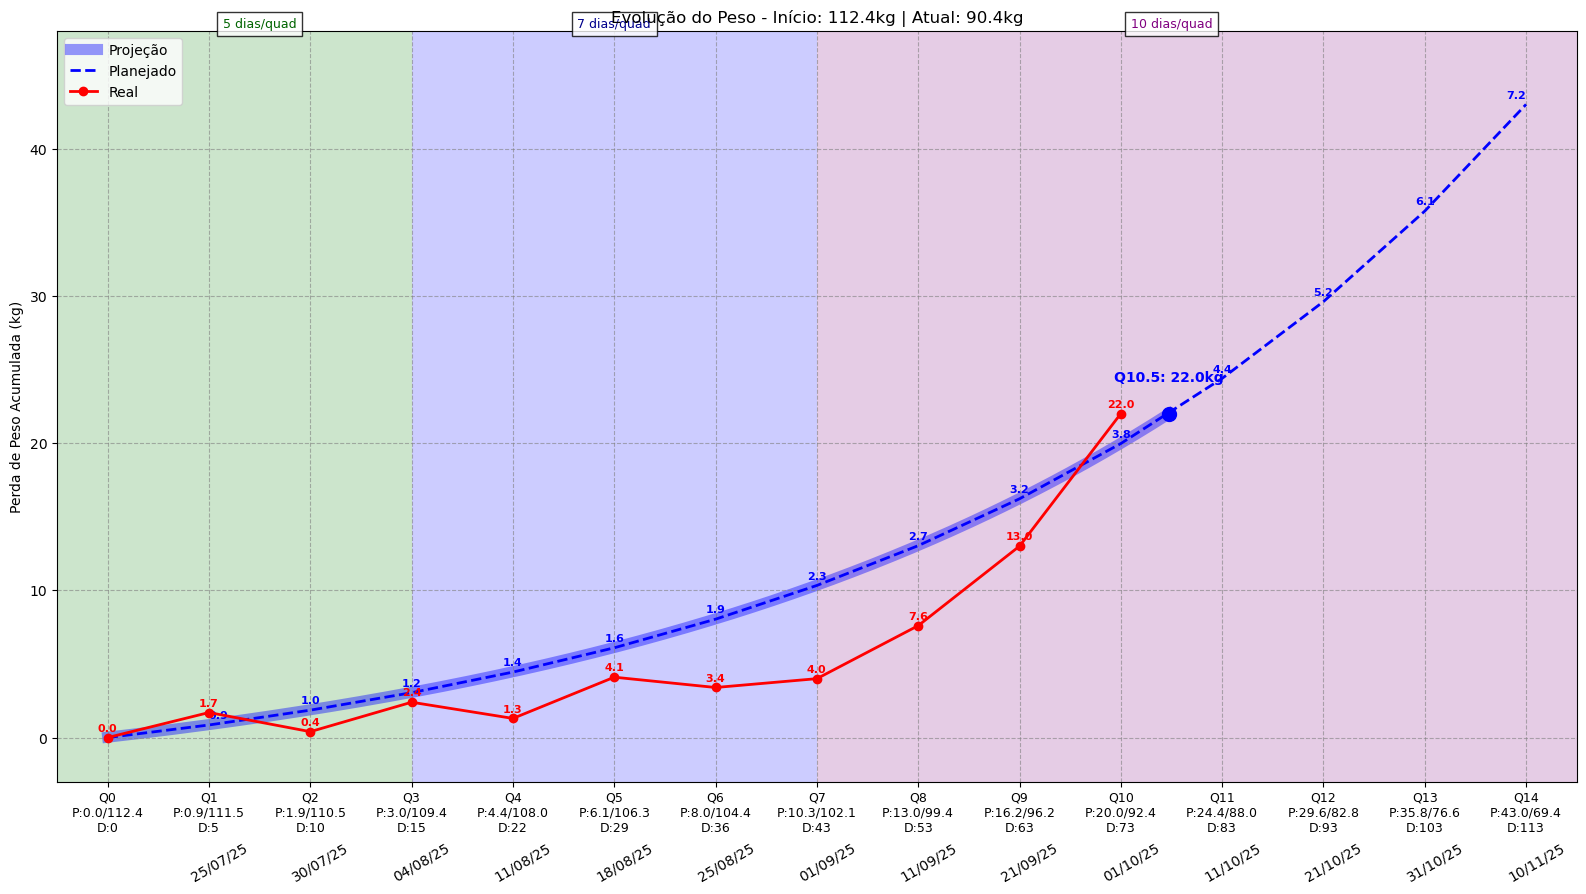

In [19]:
# ======================
# EXECUÇÃO NO JUPYTER NOTEBOOK
# ======================

# Para apenas visualizar o gráfico:
plotar_evolucao_peso()

# Para executar o programa principal no Jupyter:
#executar_programa_principal()

# Para executar apenas a calculadora Fibonacci:
# calcular_distribuicao_calistenia()


📊 Status Atual: Quadrante 6 | Peso Atual: 109.0kg
📅 Data atual: 04/09/2025
⚠️ Desvio acumulado: 2.7kg

🚨 ALERTA: DESVIO SIGNIFICATIVO DETECTADO 🚨
ANÁLISE DETALHADA DO QUADRANTE ATUAL
Perda planejada acumulada: 6.1kg
Perda real acumulada: 3.4kg
Desvio acumulado: 2.7kg (44.2%)

DETALHAMENTO DO QUADRANTE ATUAL:
 - Planejado para este quadrante: 1.9kg
 - Realizado neste quadrante: -0.7kg
 - Falta para meta do quadrante: 2.6kg

OPÇÕES:
1. Avançar para próximo quadrante (Q7)
2. Visualizar gráfico de evolução
0. Entrar em modo emergência
99. Calculadora de Calistenia



Escolha uma opção:  99



🧮 CALCULADORA DE CALISTENIA


Valor total de repetições (0 para modo automático):  210
Número de blocos principais:  4
Número de subblocos por bloco:  7



DESAFIO 210x
94x = [38, 23, 14, 10, 9]
58x = [24, 14, 11, 9]
35x = [15, 11, 9]
23x = [10, 7, 6]



Pressione Enter para continuar... 99



📊 Status Atual: Quadrante 6 | Peso Atual: 109.0kg
📅 Data atual: 05/09/2025
⚠️ Desvio acumulado: 2.7kg

🚨 ALERTA: DESVIO SIGNIFICATIVO DETECTADO 🚨
ANÁLISE DETALHADA DO QUADRANTE ATUAL
Perda planejada acumulada: 6.1kg
Perda real acumulada: 3.4kg
Desvio acumulado: 2.7kg (44.2%)

DETALHAMENTO DO QUADRANTE ATUAL:
 - Planejado para este quadrante: 1.9kg
 - Realizado neste quadrante: -0.7kg
 - Falta para meta do quadrante: 2.6kg

OPÇÕES:
1. Avançar para próximo quadrante (Q7)
2. Visualizar gráfico de evolução
0. Entrar em modo emergência
99. Calculadora de Calistenia



Escolha uma opção:  2


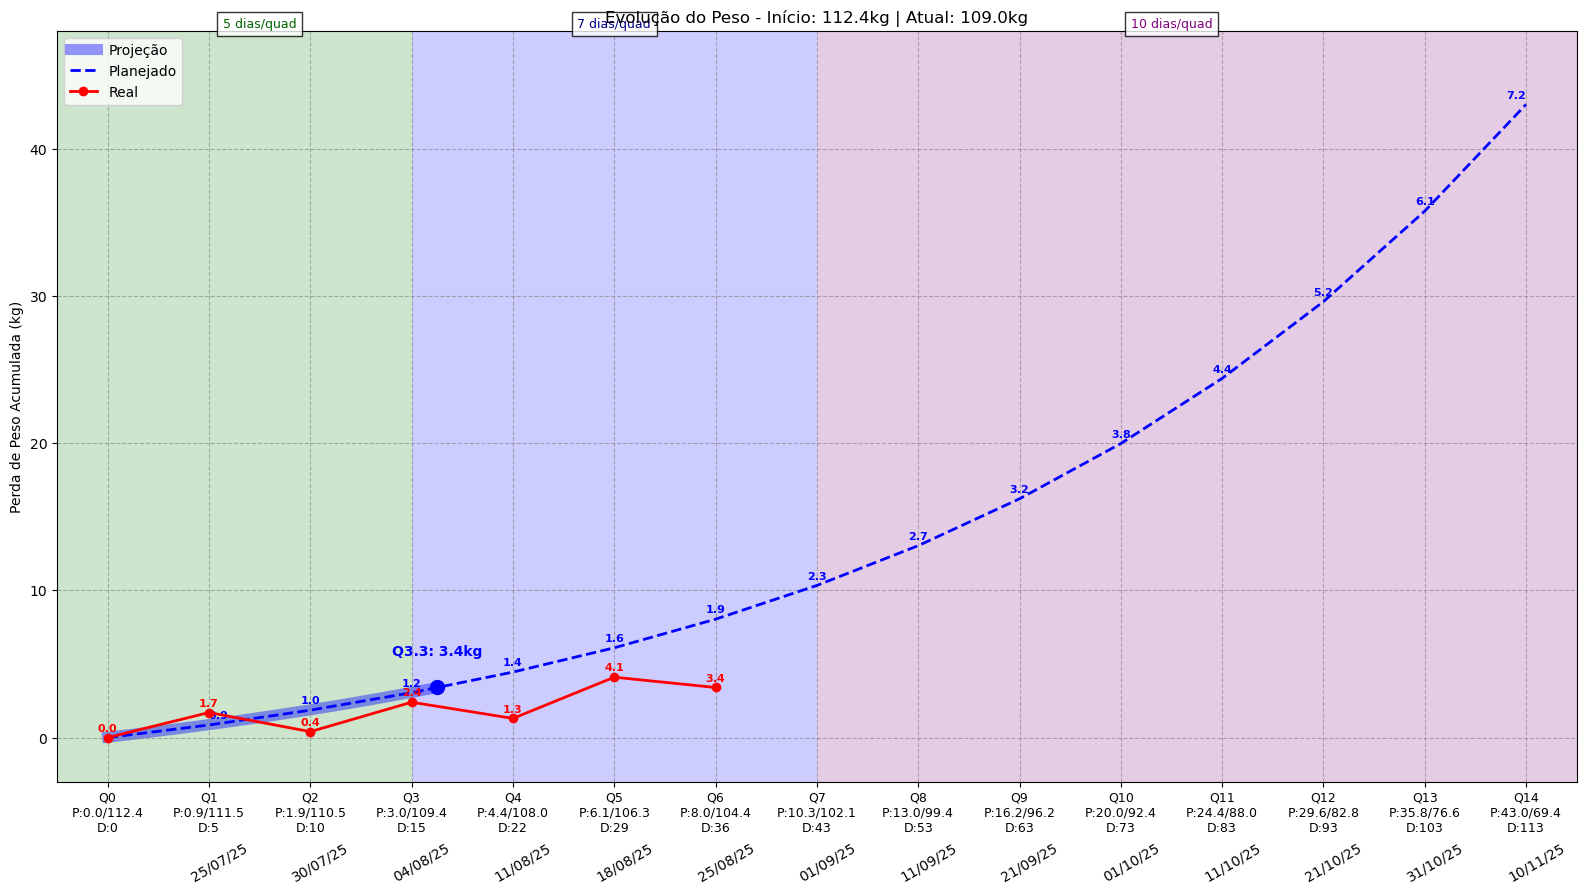

In [3]:
# Para executar o programa principal no Jupyter:
executar_programa_principal()

In [65]:
!pip install ipywidgets

In [64]:
import json
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Função de progressão da perda de peso com parâmetro de acentuação
def f(x, acentuacao=1.0):
    """Função de progressão da perda de peso com controle de acentuação."""
    return 0.6 * (10 ** (x / (14 * acentuacao)))

def configurar_quadrantes(num_quadrantes=14, acentuacao=1.0):
    """Configura dias e metas por quadrante com número variável de quadrantes."""
    x_points = np.arange(0, num_quadrantes + 1, 1)
    y_plan = f(x_points, acentuacao)
    
    # Ajustar soma total para ~43kg
    target_total = 43
    scale_factor = target_total / np.sum(y_plan[1:num_quadrantes+1])
    y_plan *= scale_factor
    y_plan[0] = 0  # Quadrante 0 = 0kg
    
    # Dias por quadrante (Q0 a QN)
    dias_por_quadrante = [0]  # Q0
    for i in range(1, num_quadrantes + 1):
        if i <= 3:
            dias_por_quadrante.append(5)    # Q1-Q3: verde
        elif i <= 7:
            dias_por_quadrante.append(7)    # Q4-Q7: azul
        else:
            dias_por_quadrante.append(10)   # Q8+: roxo
    
    return x_points, y_plan, dias_por_quadrante

def plotar_evolucao_peso_interativo(peso_inicial=112.4, data_inicio="2025-07-20", 
                                   num_quadrantes=14, acentuacao=1.0):
    """Função interativa para plotar a evolução do peso com parâmetros ajustáveis."""
    # Converter data de início
    try:
        data_inicio = datetime.strptime(data_inicio, "%Y-%m-%d")
    except:
        data_inicio = datetime(2025, 7, 20)
        print("Data inválida. Usando data padrão: 2025-07-20")
    
    # Configurar quadrantes com parâmetros fornecidos
    x_points, y_plan, dias_por_quadrante = configurar_quadrantes(num_quadrantes, acentuacao)
    
    # Pontos Planejado (curva suave)
    x_curve = np.linspace(0, num_quadrantes, 430)
    y_curve = f(x_curve, acentuacao)
    
    # Ajustar escala
    scale_factor = np.sum(y_plan[1:]) / np.sum(y_curve[1:num_quadrantes+1])
    y_curve *= scale_factor
    y_plan_adjusted = y_plan.copy()
    
    # Quadrante 0 = ponto zero (0kg)
    y_plan_adjusted[0] = 0
    accum_plan = np.cumsum(y_plan_adjusted)
    
    # Criar função de interpolação para a curva suave
    accum_curve = np.cumsum(y_curve) * (accum_plan[-1] / np.sum(y_curve))
    
    # Calcular dias acumulados por fase
    dias_acumulados = [0]
    datas_formatadas = [data_inicio.strftime('%d/%m/%y')]
    
    for i in range(1, min(4, num_quadrantes + 1)):
        dias_acumulados.append(dias_acumulados[-1] + 5)
        nova_data = data_inicio + timedelta(days=dias_acumulados[-1])
        datas_formatadas.append(nova_data.strftime('%d/%m/%y'))
    
    for i in range(4, min(8, num_quadrantes + 1)):
        dias_acumulados.append(dias_acumulados[-1] + 7)
        nova_data = data_inicio + timedelta(days=dias_acumulados[-1])
        datas_formatadas.append(nova_data.strftime('%d/%m/%y'))
    
    for i in range(8, num_quadrantes + 1):
        dias_acumulados.append(dias_acumulados[-1] + 10)
        nova_data = data_inicio + timedelta(days=dias_acumulados[-1])
        datas_formatadas.append(nova_data.strftime('%d/%m/%y'))
    
    # PLOTAGEM
    plt.figure(figsize=(16, 9))
    ax = plt.gca()
    
    # Fases coloridas no fundo
    ax.axvspan(-0.5, 3, color='green', alpha=0.2, lw=0)
    ax.axvspan(3, 7, color='blue', alpha=0.2, lw=0)
    ax.axvspan(7, num_quadrantes + 0.5, color='purple', alpha=0.2, lw=0)
    
    max_y = accum_plan.max() + 5
    
    if num_quadrantes >= 3:
        plt.text(1.5, max_y, '5 dias/quad', ha='center', va='bottom', 
                color='darkgreen', fontsize=9, bbox=dict(facecolor='white', alpha=0.8))
    
    if num_quadrantes >= 7:
        plt.text(5, max_y, '7 dias/quad', ha='center', va='bottom',
                color='darkblue', fontsize=9, bbox=dict(facecolor='white', alpha=0.8))
    
    if num_quadrantes > 7:
        plt.text((7 + num_quadrantes) / 2, max_y, '10 dias/quad', ha='center', va='bottom',
                color='purple', fontsize=9, bbox=dict(facecolor='white', alpha=0.8))
    
    # Planejado
    plt.plot(x_points, accum_plan, color='blue', linestyle='--', linewidth=2, label='Planejado', zorder=2)
    
    # Rótulos na linha azul
    for i, val in enumerate(y_plan_adjusted):
        if i == 0:
            continue
        ha = 'left' if i == 1 else ('right' if i == num_quadrantes else 'center')
        plt.text(x_points[i], accum_plan[i] + 0.3, f'{val:.1f}',
                color='blue', fontsize=8, ha=ha, va='bottom', weight='bold', zorder=3)
    
    # Eixo X com rótulos principais
    x_tick_labels = []
    for i in range(len(accum_plan)):
        if i == 0:
            main_label = f'Q{i}\nP:0.0/{peso_inicial:.1f}\nD:0'
        else:
            peso_projetado = peso_inicial - accum_plan[i]
            main_label = f'Q{i}\nP:{accum_plan[i]:.1f}/{peso_projetado:.1f}\nD:{dias_acumulados[i]}'
        x_tick_labels.append(main_label)
    
    ax.set_xticks(x_points)
    ax.set_xticklabels(x_tick_labels, fontsize=9)
    
    # Adicionar rótulos de data
    for i in range(1, min(len(x_points), len(datas_formatadas))):
        ax.text(x_points[i] - 0.2, -7.0, datas_formatadas[i], 
                rotation=30, ha='left', va='top', fontsize=10, color='black')
    
    # Configurações finais
    plt.ylabel('Perda de Peso Acumulada (kg)')
    plt.title(f'Evolução do Peso - Início: {peso_inicial}kg | Meta: {peso_inicial - accum_plan[-1]:.1f}kg')
    plt.xlim(-0.5, num_quadrantes + 0.5)
    plt.ylim(-3, max_y)
    plt.grid(True, linestyle='--', alpha=0.6, color='gray')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Criar interface interativa usando a função interact
interact(plotar_evolucao_peso_interativo, 
         peso_inicial=widgets.FloatSlider(value=112.4, min=80.0, max=150.0, step=0.1, description='Peso Inicial'),
         data_inicio=widgets.Text(value='2025-07-20', description='Data Início'),
         num_quadrantes=widgets.IntSlider(value=14, min=1, max=20, step=1, description='Nº Quadrantes'),
         acentuacao=widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.1, description='Acentuação'));

interactive(children=(FloatSlider(value=112.4, description='Peso Inicial', max=150.0, min=80.0), Text(value='2…